In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/vector_data_tesla.csv')
data.drop(columns='Unnamed: 0',inplace=True)

In [3]:
def neg_pos(value):
    if value =='positive':
        return 1
    else:
        return 0
data['target'] = data['target'].apply(neg_pos)
X = data.drop(columns=['date','target']).copy()

In [4]:
X=X.loc[:,('0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16',
'17','18','19','20','21','22','23','24','25')].copy()
y = data.loc[:, ('target')].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [5]:
def plot_fpr_tpr(fpr,tpr,title):
    plt.figure(figsize=(10,4))
    plt.plot(fpr,tpr)
    plt.title(title)
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.show()

In [6]:
#logisitic regression

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

Accuracy score of Logistic Regression- 84%


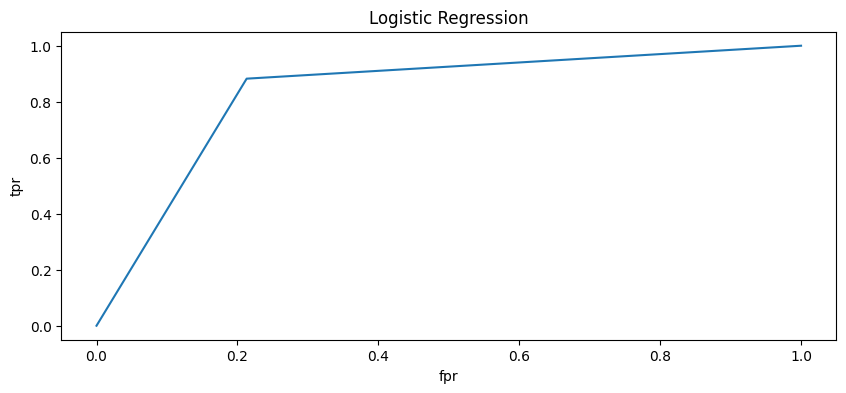

In [7]:
y_pred = log_reg.predict(X_train)
print(f'Accuracy score of Logistic Regression-{accuracy_score(y_train,y_pred)*100 : .0f}%')

fpr, tpr, thresholds = roc_curve(y_train,y_pred)
plot_fpr_tpr(fpr,tpr,"Logistic Regression")

In [8]:
svm_clf = SVC()

In [9]:
svm_clf.fit(X_train,y_train)

SVC()

SVM accuracy -  84.25%


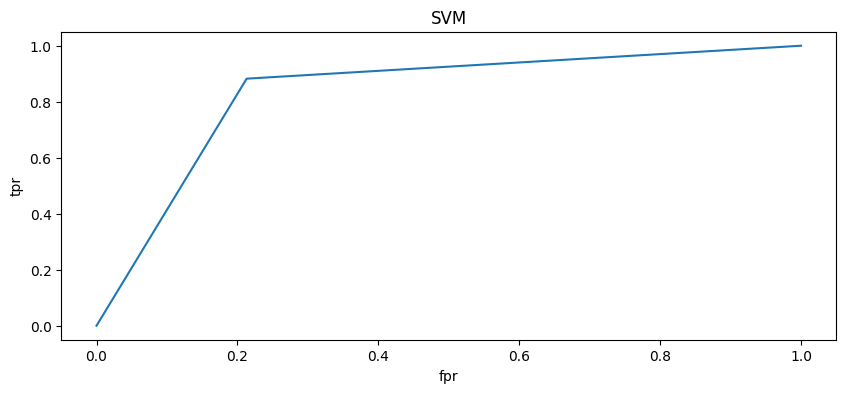

In [10]:
y_preds = svm_clf.predict(X_train)
print(f"SVM accuracy - {accuracy_score(y_pred,y_train)*100 : .2f}%")
fpr, tpr, thresholds = roc_curve(y_train,y_pred)

plot_fpr_tpr(fpr,tpr,"SVM")

In [11]:
mat = confusion_matrix(y_train,y_preds)
print(mat)

[[ 98  24]
 [  4 166]]


In [12]:
ypred_test = svm_clf.predict(X_test)
accuracy_score(y_test,ypred_test)

0.7397260273972602

In [13]:
predictions = []
for value in y_preds:
    predictions.append(value)
for value in ypred_test:
    predictions.append(value)

In [17]:
### importing the data and merging the predictions
## Analysis

df = pd.read_csv('./data/stock_yfinance_data.csv')
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA


In [29]:
#i will only consider the close price

price_with_date = df.loc[:, ('Date','Close','Stock Name')].copy()
price_with_date.head()

,Date,Close,Stock Name
0,2021-09-30,258.493347,TSLA
1,2021-10-01,258.406677,TSLA
2,2021-10-04,260.510010,TSLA
3,2021-10-05,260.196655,TSLA
4,2021-10-06,260.916656,TSLA


In [28]:
#as the dates are in reverse to other dataset i will reverse the predictions list

new_pred = predictions[::-1]

In [34]:
tesla_price = price_with_date.loc[price_with_date['Stock Name'] == 'TSLA'].copy()

In [185]:
tesla_price.shape

(252, 3)

##### As we can see from the above, the data point vary because in a year there are only 252 trading sessions. so, i will add dates which are missing and retain the same closing price for those dates

In [36]:
tesla_price['Date'] = pd.to_datetime(tesla_price['Date'])

In [51]:
dates = data['date'][::-1].values
dates = pd.to_datetime(dates)

In [168]:
#looping through the dates of our tweets and ading the dates that is been not present in the stock price

ag_data = pd.DataFrame(data=None,columns=["Date","Close"])
index = 0
for date in (dates):

    #check whether date(tweet) == (stock)
    if date != tesla_price.loc[index]['Date']:
        helper = pd.DataFrame(data = tesla_price.loc[index-1]["Close"].reshape(1,1),columns=["Close"])
        helper['Date'] = date
        ag_data = pd.concat([ag_data,helper],axis=0)
        #print(index)
    else:
        helper = pd.DataFrame(data = tesla_price.loc[index][["Date","Close"]].values.reshape(1,2),columns=["Date","Close"])
        ag_data = pd.concat([ag_data,helper],axis=0)
        index = index+1

ag_data.reset_index(drop=True, inplace=True)

In [169]:
ag_data['sentiment'] = new_pred
ts_data = ag_data.copy()
ts_data['sentiment'] = ts_data['sentiment'].map({0:0.3,1:0.8})

In [215]:
#scaling values between 0 and 1 to match the bar plot

def min_max_scaling(value, minimum, maximum):
    nom = value - minimum
    den = maximum - minimum

    scaled = nom/den
    return scaled 
ts_data['scaled_price'] = ts_data['Close'].apply(min_max_scaling, minimum=ts_data['Close'].min(), maximum=ts_data['Close'].max())

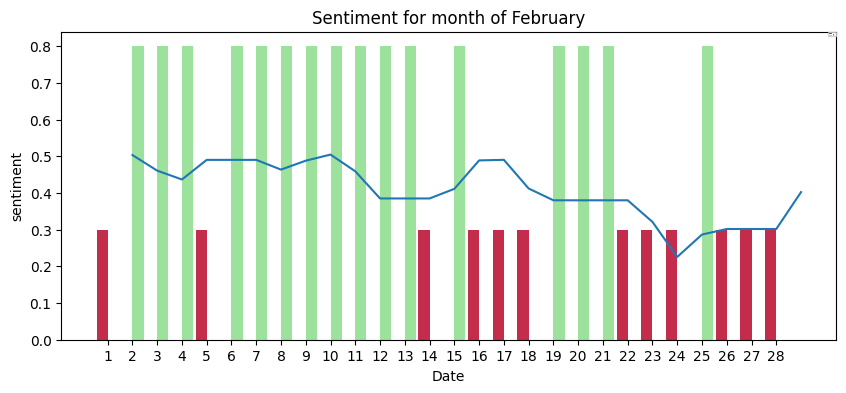

In [273]:
import seaborn as sns

selected_month = int(input("Enter month : "))

if selected_month >12 or selected_month <0:
    
    print("Enter correct Month.")

else:

    plt.figure(figsize=(10,4))

    ts_temp = ts_data.loc[ts_data['Date'].dt.month == selected_month].copy()
    ts_temp.reset_index(drop=True, inplace=True)

    sns.barplot(data=ts_temp,x=ts_temp['Date'].dt.day,y=ts_temp['sentiment'],hue=ts_temp['sentiment'],width=0.9,palette=["crimson","lightgreen"])
    sns.lineplot(data=ts_temp, x=ts_temp['Date'].dt.day, y=ts_temp['scaled_price'])
    plt.legend(loc=None, fontsize=0)

    month = ts_temp['Date'].dt.month_name()[0]
    plt.title(f"Sentiment for month of {month}")
    plt.show()

In [267]:
#storing price reaction negative or positive
def pos_or_neg(value,ag_data):
    
    results = []
    for index, sent in enumerate(ag_data['sentiment']):
        if sent == value or index==0:
            results.append("NaN")
        else:
            val = ag_data.loc[index]['sentiment'] - ag_data.loc[index-1]['sentiment']
            results.append("positive") if val >0 else results.append("negative")
    return results

In [272]:
results_pos = pos_or_neg(0,ag_data=ag_data)
increase = results_pos.count("positive")
decrease = results_pos.count("negative")

perc = increase / (increase+decrease)
print(f"Percentage of price increase when the tweets sentiment were positive : {perc*100: .2f}%")

Percentage of price increase when the tweets sentiment were positive :  34.45%
